In [1]:
!pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.8 MB/s eta 0:00:00:00:010:01


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import tqdm

import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from catboost import CatBoostClassifier

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def evaluate_binary_classification(y_true, y_pred, pos_label='Positive'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=pos_label, average='binary')
    recall = recall_score(y_true, y_pred, pos_label=pos_label, average='binary')
    f1 = f1_score(y_true, y_pred, pos_label=pos_label, average='binary')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Baseline

In [6]:
data = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/train.csv', sep='\t')
data

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...
...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро..."
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка..."
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...


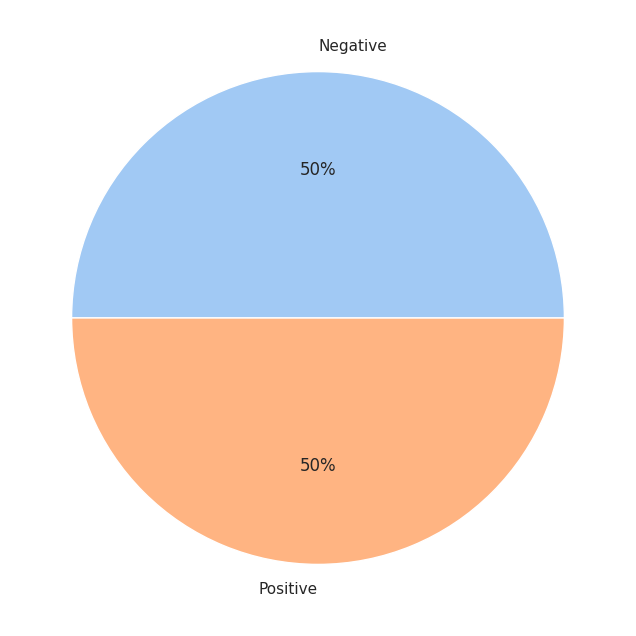

In [7]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['Score'].unique())
dt = np.array([len(data[data['Score'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [8]:
data['Text_clear'] = data['Text'].apply(lambda x: re.sub("[^a-zA-Zа-яА-ЯёЁ]", " ", x).lower())
data['Text'] = data['Text'].apply(lambda x: x.lower())

In [9]:
morph = pymorphy2.MorphAnalyzer()

In [10]:
# text = data['Text'][0]  # Замените на ваш текст

# # Токенизация и лемматизация
# lemmatized_text = ' '.join(
#     morph.parse(word)[0].normal_form for word in nltk.word_tokenize(text, language="russian") if word not in s_w
# )

# print(lemmatized_text)

In [11]:
import string


s_w = stopwords.words('russian')

for elem in string.punctuation:
    data['Text_clear'] = data['Text_clear'].apply(lambda x: x.replace(elem, ''))
data['Text_clear'] = data['Text_clear'].apply(lambda x: ' '.join(x.split()))

# Text_lemmatize = []
# for x in tqdm_notebook(data['Text_clear']):
#     Text_lemmatize.append(' '.join(
#     morph.parse(word)[0].normal_form for word in nltk.word_tokenize(x, language="russian") if not word in s_w
# ).lower())
# data['Text_lemmatize'] = Text_lemmatize
# Text_lemmatize.clear()

In [12]:
data

,idx,Score,Text,Text_clear
0,0,Positive,в альфа-банке работает замечательная девушка -...,в альфа банке работает замечательная девушка и...
1,1,Negative,оформляя рассрочку в м. видео в меге тёплый ст...,оформляя рассрочку в м видео в меге тёплый ста...
2,2,Positive,очень порадовала оперативность работы в банке....,очень порадовала оперативность работы в банке ...
3,3,Negative,имела неосторожность оформить потреб. кредит в...,имела неосторожность оформить потреб кредит в ...
4,4,Negative,небольшая предыстория: нашел на сайте mdm банк...,небольшая предыстория нашел на сайте mdm банка...
...,...,...,...,...
13994,13994,Positive,"о высокой надёжности мкб, порядочности и добро...",о высокой надёжности мкб порядочности и доброс...
13995,13995,Positive,"обслуживаюсь в офисе на чернореченской 42а, ка...",обслуживаюсь в офисе на чернореченской а как ф...
13996,13996,Positive,попала сегодня в очень неприятную ситуацию. ре...,попала сегодня в очень неприятную ситуацию реш...
13997,13997,Positive,добрый день! давно являюсь клиентом банка русс...,добрый день давно являюсь клиентом банка русск...


In [13]:
X = data.drop(columns=['Score', 'idx', 'Text'])
Y = data['Score']

In [14]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [15]:
catModel = CatBoostClassifier(
    iterations=2048,
    verbose=128,
    eval_metric='TotalF1',
    use_best_model=True,
    learning_rate=0.01,
    random_seed=42,
    l2_leaf_reg=4,
    grow_policy='Depthwise',
    depth=8,
    od_type='Iter',
    od_wait=128,
    rsm=1,
    fold_permutation_block=550,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=64,
    text_features=['Text_clear'],
    task_type='GPU'
)

catModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.9462442	test: 0.9324988	best: 0.9324988 (0)	total: 11.4s	remaining: 6h 28m 14s
128:	learn: 0.9556190	test: 0.9428510	best: 0.9432086 (109)	total: 26.1s	remaining: 6m 27s
256:	learn: 0.9626738	test: 0.9432086	best: 0.9435669 (152)	total: 39.4s	remaining: 4m 34s
384:	learn: 0.9686566	test: 0.9457068	best: 0.9457068 (381)	total: 52.1s	remaining: 3m 45s
512:	learn: 0.9750866	test: 0.9460644	best: 0.9460644 (462)	total: 1m 4s	remaining: 3m 12s
640:	learn: 0.9811587	test: 0.9482048	best: 0.9485625 (623)	total: 1m 16s	remaining: 2m 48s
768:	learn: 0.9855343	test: 0.9489192	best: 0.9489192 (667)	total: 1m 28s	remaining: 2m 27s
bestTest = 0.9489191696
bestIteration = 667
Shrink model to first 668 iterations.


In [16]:
evaluate_binary_classification(catModel.predict(X_valid), Y_valid)

{'Accuracy': 0.9489285714285715,
 'Precision': 0.9356683345246605,
 'Recall': 0.9610866372980911,
 'F1 Score': 0.9482071713147411}

In [18]:
test = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/test.csv', sep='\t')
test['Text_clear'] = test['Text'].apply(lambda x: re.sub("[^a-zA-Zа-яА-ЯёЁ]", " ", x).lower())
test['Text'] = test['Text'].apply(lambda x: x.lower())
for elem in string.punctuation:
    test['Text_clear'] = test['Text_clear'].apply(lambda x: x.replace(elem, ''))
test['Text_clear'] = test['Text_clear'].apply(lambda x: ' '.join(x.split()))
# Text_lemmatize = []
# for x in tqdm_notebook(test['Text_clear']):
#     Text_lemmatize.append(' '.join(
#     morph.parse(word)[0].normal_form for word in nltk.word_tokenize(x, language="russian") if not word in s_w
# ).lower())
# test['Text_lemmatize'] = Text_lemmatize
# Text_lemmatize.clear()

In [19]:
test

,idx,Text,Text_clear
0,13999,замечательная история об открытии счета в банк...,замечательная история об открытии счета в банк...
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп...",г я досрочно внес сумму указанную оператором и...
2,14001,была задолженность по кредитной карте. банк по...,была задолженность по кредитной карте банк под...
3,14002,срочно понадобилась определенная денежная сумм...,срочно понадобилась определенная денежная сумм...
4,14003,здравствуйте. в местном отделении бинбанка г. ...,здравствуйте в местном отделении бинбанка г ку...
...,...,...,...
5995,19994,уважаемые представители русфинанс банка! прошу...,уважаемые представители русфинанс банка прошу ...
5996,19995,04 июня сняли с дебетовой карты банка 10 000 t...,июня сняли с дебетовой карты банка twd тысяч р...
5997,19996,в апреле решил я купить шуруповерт. посмотрел ...,в апреле решил я купить шуруповерт посмотрел ц...
5998,19997,недавно взял потребкредит в этом банке. все че...,недавно взял потребкредит в этом банке все чес...


In [20]:
submit = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/sample_submission.csv', sep='\t')
submit['Score'] = catModel.predict(test.drop(columns=['idx', 'Text']))
submit.to_csv('submit_cat.csv', sep='\t', index=False)

# Воспользуемся предобученной BERT моделью с ее токенизатором

In [21]:
model_name = 'cointegrated/rubert-tiny'

In [22]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
data = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/train.csv', sep='\t')
data

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...
...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро..."
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка..."
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...


In [23]:
encode_class = {i: lab for i, lab in enumerate(data['Score'].unique())}
decode_class = {encode_class[i]: i for i in encode_class}

In [24]:
data['Score_num'] = data['Score'].apply(lambda x: decode_class[x])

In [25]:
data

,idx,Score,Text,Score_num
0,0,Positive,В Альфа-Банке работает замечательная девушка -...,0
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...,1
2,2,Positive,Очень порадовала оперативность работы в банке....,0
3,3,Negative,Имела неосторожность оформить потреб. кредит в...,1
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...,1
...,...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро...",0
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка...",0
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...,0
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...,0


In [26]:
Text_lemmatize = []
s_w = stopwords.words('russian')
data['Text_clear'] = data['Text'].apply(lambda x: re.sub("[^a-zA-Zа-яА-ЯёЁ]", " ", x) )
for x in tqdm_notebook(data['Text_clear']):
    Text_lemmatize.append(' '.join(
    morph.parse(word)[0].normal_form for word in nltk.word_tokenize(x, language="russian") if not word in s_w
).lower())
data['Text_lemmatize'] = Text_lemmatize
Text_lemmatize.clear()

  0%|          | 0/13999 [00:00<?, ?it/s]

In [27]:
data

,idx,Score,Text,Score_num,Text_clear,Text_lemmatize
0,0,Positive,В Альфа-Банке работает замечательная девушка -...,0,В Альфа Банке работает замечательная девушка ...,в альфа банк работать замечательный девушка ил...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...,1,Оформляя рассрочку в м Видео в меге тёплый ст...,оформлять рассрочка м видео мег тёплый стан по...
2,2,Positive,Очень порадовала оперативность работы в банке....,0,Очень порадовала оперативность работы в банке ...,очень порадовать оперативность работа банк зак...
3,3,Negative,Имела неосторожность оформить потреб. кредит в...,1,Имела неосторожность оформить потреб кредит в...,иметь неосторожность оформить потреба кредит а...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...,1,Небольшая предыстория Нашел на сайте MDM банк...,небольшой предыстория найти сайт mdm банк инте...
...,...,...,...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро...",0,О высокой надёжности МКБ порядочности и добро...,о высокий надёжность мкб порядочность добросов...
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка...",0,Обслуживаюсь в офисе на Чернореченской а ка...,обслуживаться офис чернореченский физ лицо год...
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...,0,Попала сегодня в очень неприятную ситуацию Ре...,попасть сегодня очень неприятный ситуация реши...
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...,0,Добрый день Давно являюсь клиентом банка Русс...,добрый день давно являться клиент банк русский...


In [28]:
X = data['Text_lemmatize']
Y = data['Score_num']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
len(X_train), len(Y_train), len(X_valid), len(Y_valid)

(11199, 11199, 2800, 2800)

In [30]:
train_tokens = tokenizer(list(X_train), padding=True, truncation=True)
valid_tokens = tokenizer(list(X_valid), padding=True, truncation=True)

In [31]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[2, 2225, 12666, 12684, 815, 28470, 7154, 28317, 5477, 751, 312, 865, 330, 4076, 1839, 5683, 721, 18348, 4159, 866, 650, 3030, 27182, 2215, 28317, 650, 12153, 16234, 19930, 331, 16598, 13949, 20666, 23016, 1725, 16803, 29039, 2215, 815, 28470, 7154, 3946, 870, 11978, 3024, 902, 26272, 1062, 1104, 2643, 2643, 831, 2643, 831, 815, 28470, 7154, 3946, 870, 11978, 3024, 902, 26272, 1062, 1104, 2643, 2643, 831, 2643, 831, 24836, 3098, 13334, 19930, 21010, 23333, 4495, 10658, 7154, 8464, 6239, 4045, 18807, 10548, 3564, 18853, 22896, 650, 16196, 872, 548, 17314, 4045, 5548, 28666, 18807, 10548, 3564, 18853, 1129, 12153, 1725, 12105, 22850, 21467, 938, 5599, 18348, 23964, 20759, 8621, 17959, 329, 13361, 4963, 324, 721, 13041, 2225, 12153, 4045, 25219, 19930, 328, 26430, 1348, 324, 721, 13041, 329, 13361, 4963, 20759, 8621, 17959, 1479, 324, 721, 13041, 7305, 10763, 15865, 1348, 17201, 29039, 1090, 28317, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

2024-07-20 07:50:40.934284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 07:50:40.934399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 07:50:41.062317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[CLS] произвести возврат средство билет ак трансаэро получить смс зачисление средство зайти интернет банк увидеть операция провестись повторно снятие возврат товар transaero moscow ru rub rub возврат товар transaero moscow ru rub rubсотрудник банк обещать разобраться течение день перезвонить создать заявка на следующий день никто перезвонить прийтись связываться сам получить ответ срок решение вопрос сказать мочь пройти день сотрудник банк решить мочь сказать срок решение вопрос также мочь предоставить информация снять средство [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [42]:
class TokenData(Dataset):
    def __init__(self, data, tokens, labels=None, train=False):
        self.text_data = data
        self.tokens = tokens
        
        if train or (labels is not None and not labels.empty):
            self.labels = list(labels)
        else:
            self.labels = []

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        if self.labels:
            sample['labels'] = torch.tensor(self.labels[idx])
        else:
            sample['labels'] = 0
        return sample

In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

class Metrics:
    @staticmethod
    def f1_score_binary(y_true, y_pred):
        return f1_score(y_true, y_pred)

    @staticmethod
    def precision_binary(y_true, y_pred):
        return precision_score(y_true, y_pred)

    @staticmethod
    def recall_binary(y_true, y_pred):
        return recall_score(y_true, y_pred)

    @staticmethod
    def accuracy_binary(y_true, y_pred):
        return accuracy_score(y_true, y_pred)
    
    @staticmethod
    def f1_score_multiclass(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    @staticmethod
    def precision_multiclass(y_true, y_pred):
        return precision_score(y_true, y_pred, average='weighted')

    @staticmethod
    def recall_multiclass(y_true, y_pred):
        return recall_score(y_true, y_pred, average='weighted')

    @staticmethod
    def accuracy_multiclass(y_true, y_pred):
        return accuracy_score(y_true, y_pred)

In [44]:
batch_size = 16
train_dataset = TokenData(X_train.to_numpy(), train_tokens, Y_train, train=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True)

valid_dataset = TokenData(X_valid.to_numpy(), valid_tokens, Y_valid, train=False)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=8, pin_memory=True)

In [49]:
class Trainer_model:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=1e-5,
            weight_decay=2e-2,
            eps=1e-9,
            amsgrad=True
        )
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2)
        self.loss_function = nn.CrossEntropyLoss()
        self.metrics_functions = Metrics
    
    def train_one_epoch(self, data_loader, num_ep):
        self.model.train(True)
        total_loss = 0.0
        total_samples = 0
        metric_res = {
            'f1_score': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'accuracy': 0.0
        }
        print(f'Epoch train: {num_ep + 1}')
        print('-----------------------------------')
        for batch_index, batch in enumerate(tqdm.notebook.tqdm(data_loader)):
            batch = {k: v.to(self.device) for k, v in batch.items()}
        
            self.optimizer.zero_grad()
            outputs = self.model(input_ids=batch['input_ids'].to(self.device), attention_mask=batch['attention_mask'].to(self.device))
            loss = self.loss_function(outputs.logits, batch['labels'])

            batch_size = batch['attention_mask'].size()[0]
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            output_argmax = torch.argmax(outputs.logits, axis=1)
            metric_res['f1_score'] += self.metrics_functions.f1_score_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += self.metrics_functions.precision_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += self.metrics_functions.recall_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += self.metrics_functions.accuracy_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size

            loss.backward()
            self.optimizer.step()

        avg_loss = total_loss / total_samples
        print(f'loss train: {avg_loss}')
        metric_res = {i: metric_res[i] / total_samples for i in metric_res}
        for metric in metric_res:
            print(f'{metric}: {metric_res[metric]}')
        return avg_loss, metric_res
    
    def validation_one_epoch(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        metric_res = {
            'f1_score': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'accuracy': 0.0
        }
        for batch_index, batch in enumerate(tqdm.notebook.tqdm(data_loader)):
            batch = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            
            loss = self.loss_function(outputs.logits, batch['labels'])

            batch_size = batch['attention_mask'].size()[0]
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            output_argmax = torch.argmax(outputs.logits, axis=1)
            metric_res['f1_score'] += self.metrics_functions.f1_score_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += self.metrics_functions.precision_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += self.metrics_functions.recall_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += self.metrics_functions.accuracy_binary(batch['labels'].cpu(), output_argmax.cpu()) * batch_size

        avg_loss = total_loss / total_samples
        print(f'Loss validation: {avg_loss}')
        metric_res = {i: metric_res[i] / total_samples for i in metric_res}
        for metric in metric_res:
            print(f'{metric}: {metric_res[metric]}')
        print('-----------------------------------')
        print()
        return avg_loss, metric_res

In [50]:
trainer = Trainer_model(model, device)

In [51]:
epoches = 32

train_losses = []
metric_res_train = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

valid_losses = []
metric_res_valid = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }


best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0
}
best_model_wts = 'model'
min_loss = 10**9

for epoch in range(epoches):

    losses_train_epoch, metric_res_train_epoch = trainer.train_one_epoch(train_loader, epoch)
    train_losses.append(losses_train_epoch)
    for i in metric_res_train_epoch:
        metric_res_train[i].append(metric_res_train_epoch[i])
    
    losses_val_epoch, metric_res_val_epoch = trainer.validation_one_epoch(valid_loader)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])
    
    if any([best_metrics[i] < metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = trainer.model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch
    
    trainer.scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.4144272344624829
f1_score: 0.8218139707613215
precision: 0.8221999805712641
recall: 0.8479153214754623
accuracy: 0.8265916599696401


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.29193799453122277
f1_score: 0.8860374168163798
precision: 0.8729304822161961
recall: 0.9103588316445461
accuracy: 0.8882142857142857
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.25009528669606085
f1_score: 0.8988106898300234
precision: 0.8945429893795821
recall: 0.9158172224338847
accuracy: 0.9030270559871417


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.26159085099186213
f1_score: 0.8933843143683998
precision: 0.916706594992309
recall: 0.8823286713286714
accuracy: 0.9
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.2068689541804896
f1_score: 0.9181575523415313
precision: 0.9138246757855651
recall: 0.9346156973266537
accuracy: 0.9224037860523261


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.23168455124965737
f1_score: 0.914448771338612
precision: 0.8916218860504572
recall: 0.9479923092780237
accuracy: 0.9153571428571429
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.1760038744446337
f1_score: 0.9310286598765959
precision: 0.9258100294800005
recall: 0.945998197217057
accuracy: 0.9353513706580945


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.208211589508823
f1_score: 0.9183455435662496
precision: 0.9226025720311433
recall: 0.9227992959421532
accuracy: 0.9217857142857143
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.15183995542504744
f1_score: 0.9418748454635358
precision: 0.9351680544554911
recall: 0.9566093855941163
accuracy: 0.9454415572819002


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.21800174278872353
f1_score: 0.9221468490558812
precision: 0.8898073672359383
recall: 0.9651786626072343
accuracy: 0.9217857142857143
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.13767163232348095
f1_score: 0.9489382097747628
precision: 0.9444213712094777
recall: 0.9603404958883124
accuracy: 0.9511563532458255


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.20132162908890416
f1_score: 0.9251666737188223
precision: 0.9366938934081788
recall: 0.9226362367790939
accuracy: 0.9296428571428571
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.12349990037804534
f1_score: 0.9554685537111631
precision: 0.9529442182268333
recall: 0.9645535086199432
accuracy: 0.9578533797660506


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.1981039444144283
f1_score: 0.9285774809737736
precision: 0.9139267716410572
recall: 0.9506385677814251
accuracy: 0.9307142857142857
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.10950453938416194
f1_score: 0.9601365391561122
precision: 0.954911356465067
recall: 0.9703484181383992
accuracy: 0.9622287704259309


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.20807120855631572
f1_score: 0.9233753826385865
precision: 0.9349367299367299
recall: 0.9205770737199309
accuracy: 0.9275
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.09886369839508903
f1_score: 0.9656220515878169
precision: 0.9620071151279297
recall: 0.9741144886604305
accuracy: 0.9670506295204929


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.20250489297455976
f1_score: 0.9291495192763275
precision: 0.9268090639519208
recall: 0.9399038739038741
accuracy: 0.9317857142857143
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.08326354424717576
f1_score: 0.9708214409122032
precision: 0.9671802515627859
recall: 0.9783936950826851
accuracy: 0.9724082507366729


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.21347500479380999
f1_score: 0.9318576994837557
precision: 0.9279060146203002
recall: 0.9434254158539875
accuracy: 0.9339285714285714
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.07089729960839848
f1_score: 0.9771149452820467
precision: 0.9722244776088871
recall: 0.9849750551063167
accuracy: 0.9783909277614072


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.22264613602842603
f1_score: 0.9240065987859459
precision: 0.9382739799882656
recall: 0.9189104070532642
accuracy: 0.9278571428571428
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06894420503941974
f1_score: 0.9766679010930474
precision: 0.9722188180800555
recall: 0.9842466350904607
accuracy: 0.9787481025091526


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2233778346383146
f1_score: 0.9253137883284296
precision: 0.9400517577660434
recall: 0.9195453276881849
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06839775338207454
f1_score: 0.9787777366146758
precision: 0.9731434879573109
recall: 0.987281377530507
accuracy: 0.9798196267523887


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.22586476481652687
f1_score: 0.9244605930692193
precision: 0.9399027163312877
recall: 0.9180147154432869
accuracy: 0.9285714285714286
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.0656530076501646
f1_score: 0.9794638896614083
precision: 0.9755146342877395
recall: 0.9862088799672509
accuracy: 0.9802660951870703


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2238709045880075
f1_score: 0.9246788676935089
precision: 0.9389089006231862
recall: 0.9195453276881849
accuracy: 0.9285714285714286
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06561460711327405
f1_score: 0.9798520290835129
precision: 0.9770461087364382
recall: 0.985309639314461
accuracy: 0.9806232699348156


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2220188841995384
f1_score: 0.924683843110249
precision: 0.9367660434803291
recall: 0.9211326292754866
accuracy: 0.9282142857142858
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06502627186957524
f1_score: 0.9796261147230542
precision: 0.9749911546321941
recall: 0.9872025267149835
accuracy: 0.9808018573086883


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2208479834693883
f1_score: 0.9256411080675142
precision: 0.9351243201243202
recall: 0.9243525839240126
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 17
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.067024325481075
f1_score: 0.9762483590852804
precision: 0.9728981292937894
recall: 0.9830597607787533
accuracy: 0.9783909277614072


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.22087268307139832
f1_score: 0.9256411080675142
precision: 0.9351243201243202
recall: 0.9243525839240126
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 18
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06866310819343474
f1_score: 0.9793265611559682
precision: 0.9740180209507828
recall: 0.9874674997096641
accuracy: 0.9803553888740066


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2210326991349991
f1_score: 0.9256411080675142
precision: 0.9351243201243202
recall: 0.9243525839240126
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 19
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06382664439580847
f1_score: 0.9798020709114823
precision: 0.9737112011422219
recall: 0.988511275411892
accuracy: 0.9808018573086883


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.22142997369968465
f1_score: 0.9256362240626301
precision: 0.9369020979020979
recall: 0.9229013367584796
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 20
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06923071680392087
f1_score: 0.9757814734354963
precision: 0.9704664745717521
recall: 0.9844072546992455
accuracy: 0.9776765782659166


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.2215804921928793
f1_score: 0.9256362240626301
precision: 0.9369020979020979
recall: 0.9229013367584796
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 21
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

loss train: 0.06671374400056242
f1_score: 0.9791953602150513
precision: 0.9736794602050426
recall: 0.9875954387607213
accuracy: 0.9800875078131976


  0%|          | 0/175 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loss validation: 0.22163490127106864
f1_score: 0.9256362240626301
precision: 0.9369020979020979
recall: 0.9229013367584796
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 22
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

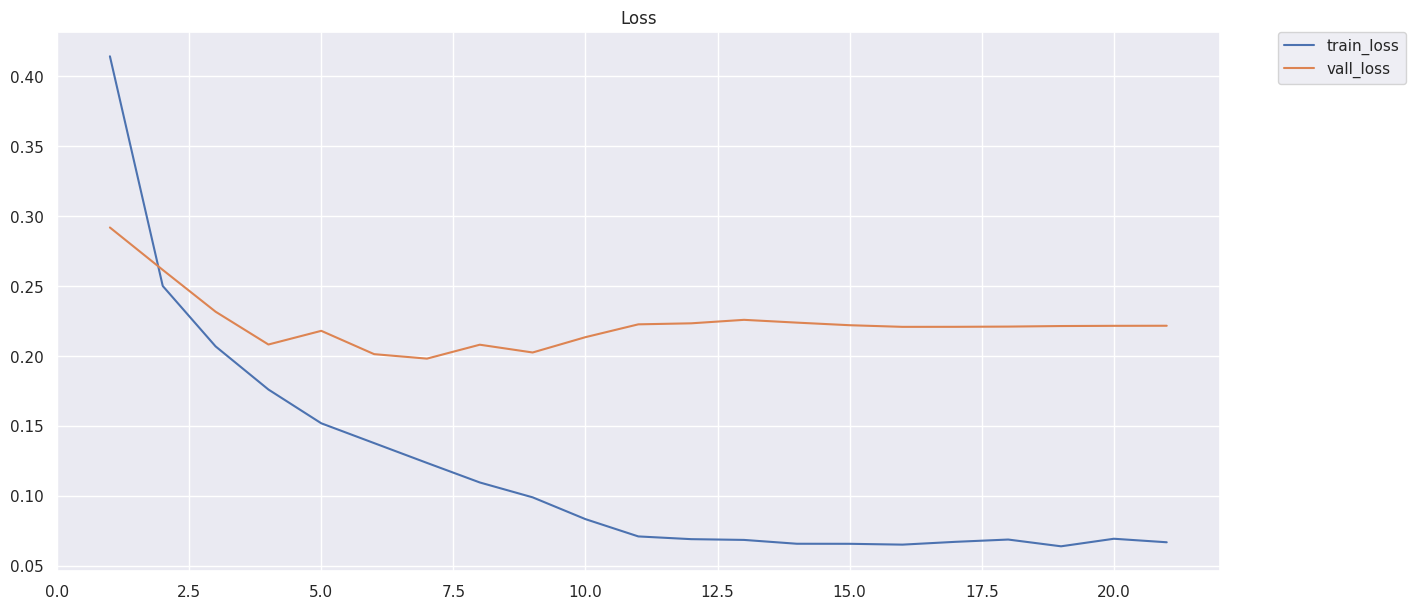

In [52]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

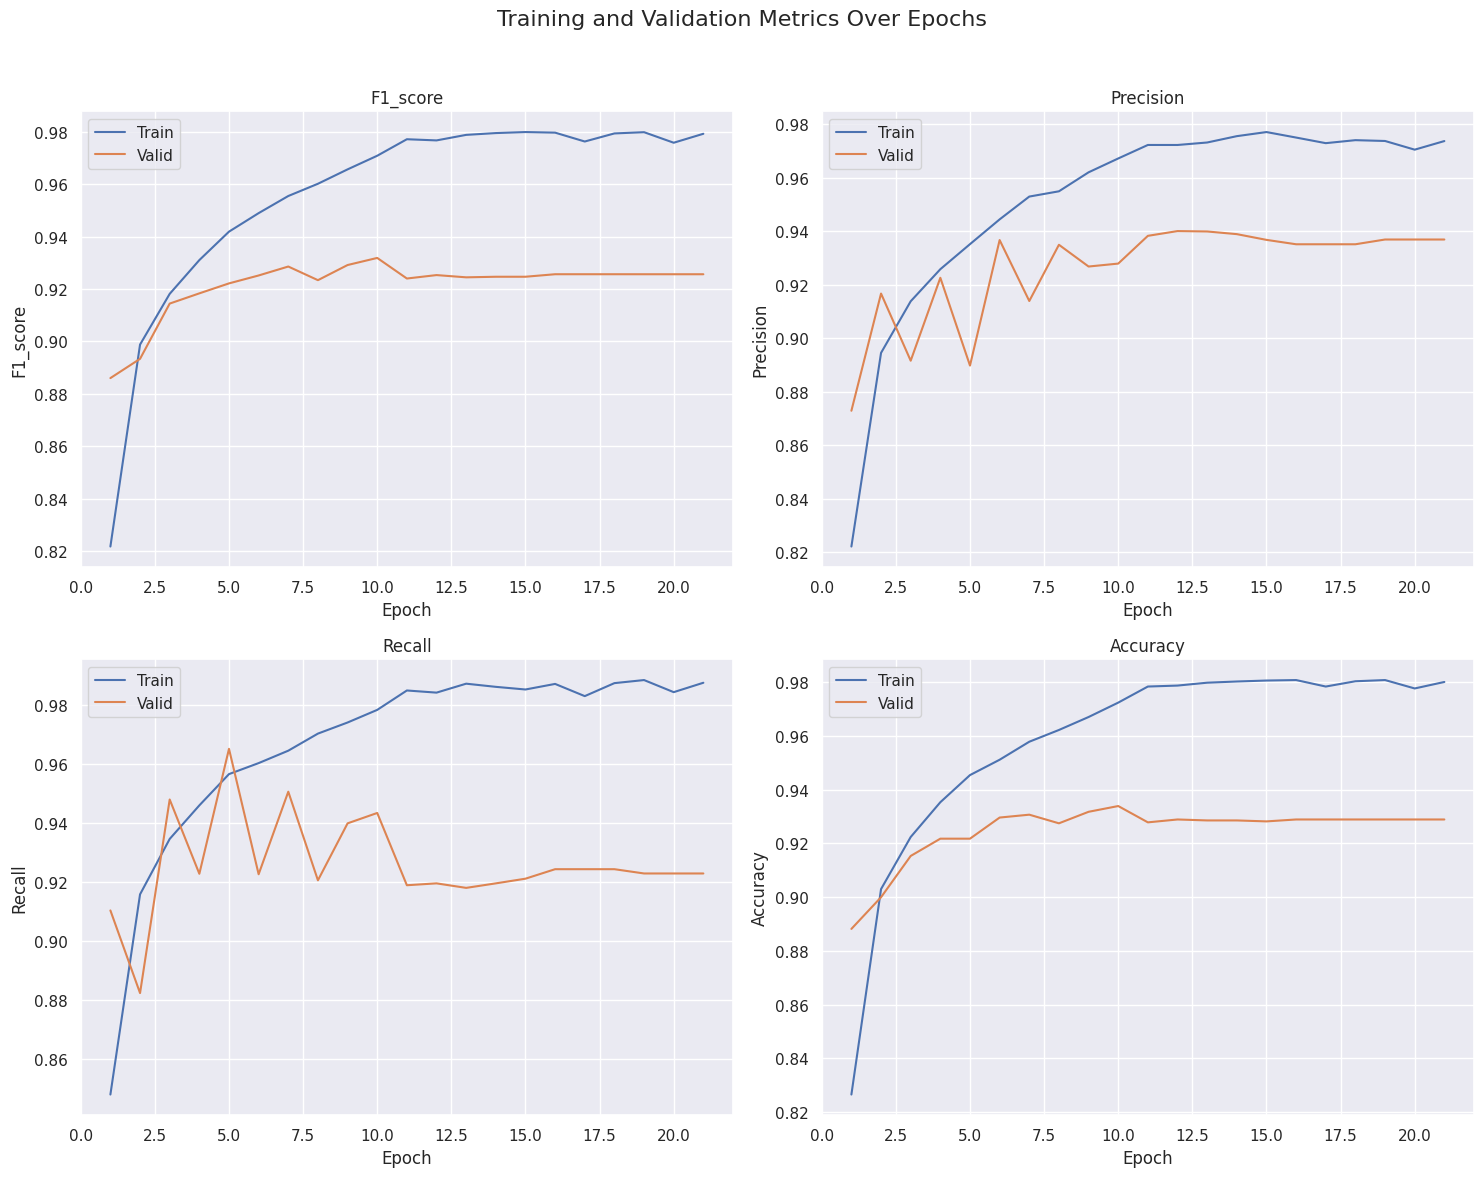

In [56]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [55]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')
model = trainer.model
model.load_state_dict(best_model_wts)

best_metrics: {'f1_score': 0.9285774809737736, 'precision': 0.9139267716410572, 'recall': 0.9506385677814251, 'accuracy': 0.9307142857142857}
best_loss: 0.1981039444144283


<All keys matched successfully>

In [58]:
test = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/test.csv', sep='\t')
Text_lemmatize = []
s_w = stopwords.words('russian')
test['Text_clear'] = test['Text'].apply(lambda x: re.sub("[^a-zA-Zа-яА-ЯёЁ]", " ", x) )
for x in tqdm_notebook(test['Text_clear']):
    Text_lemmatize.append(' '.join(
    morph.parse(word)[0].normal_form for word in nltk.word_tokenize(x, language="russian") if not word in s_w
).lower())
test['Text_lemmatize'] = Text_lemmatize
Text_lemmatize.clear()
test

  0%|          | 0/6000 [00:00<?, ?it/s]

,idx,Text,Text_clear,Text_lemmatize
0,13999,Замечательная история об открытии счета в банк...,Замечательная история об открытии счета в банк...,замечательный история открытие счёт банк аванг...
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп...",г я досрочно внес сумму указанную оп...,г досрочно внести сумма указанный оператор зак...
2,14001,Была задолженность по кредитной карте. Банк по...,Была задолженность по кредитной карте Банк по...,быть задолженность кредитный карта банк подать...
3,14002,Срочно понадобилась определенная денежная сумм...,Срочно понадобилась определенная денежная сумм...,срочно понадобиться определённый денежный сумм...
4,14003,Здравствуйте. В местном отделении Бинбанка г. ...,Здравствуйте В местном отделении Бинбанка г ...,здравствуйте в местный отделение бинбанка г ку...
...,...,...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...,Уважаемые представители Русфинанс Банка Прошу...,уважаемый представитель русфинанс банк просить...
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...,июня сняли с дебетовой карты банка T...,июнь снять дебетовый карта банк twd тысяча руб...
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...,В апреле решил я купить шуруповерт Посмотрел ...,в апрель решить купить шуруповерт посмотреть ц...
5998,19997,Недавно взял потребкредит в этом банке. Все че...,Недавно взял потребкредит в этом банке Все че...,недавно взять потребкредить банк всё честно ме...


In [59]:
test_tokens = tokenizer(list(test['Text_lemmatize']), padding=True, truncation=True)
test_tokens_sample = {}
for k, v in test_tokens.items():
    test_tokens_sample[k] = torch.tensor(v).to(device)

In [60]:
batch_size = 16
test_loader_input_ids = DataLoader(test_tokens_sample['input_ids'], shuffle=False, batch_size=batch_size)
test_loader_attention_mask = DataLoader(test_tokens_sample['attention_mask'], shuffle=False, batch_size=batch_size)

In [64]:
model.eval()
res = []
with torch.no_grad():
    for batch in tqdm.notebook.tqdm(zip(test_loader_input_ids, test_loader_attention_mask)):
        outputs = model(
            input_ids=batch[0],
            attention_mask=batch[1]
        )
        res.extend((torch.argmax(outputs.logits, axis=1).to('cpu')).tolist())

0it [00:00, ?it/s]

In [65]:
encode_class

{0: 'Positive', 1: 'Negative'}

In [66]:
submit = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/sample_submission.csv', sep='\t')
submit['Score'] = res
submit['Score'] = submit['Score'].apply(lambda x: encode_class[x])
submit.to_csv('submit_BERT.csv', sep='\t', index=False)